# Ensemble methods using decision trees (18 marks)

In [1]:
#Import Libraries

import os
import numpy as np
import pandas as pd  # use pandas to load data from CSV files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

In [2]:
# Loading the data

data_path = "activity_recognition_dataset/S1_Dataset"
files = os.listdir(data_path)

combined_data = []

for file in files:    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file (Dataframe)
        # The CSV files have columns without a header, so header=None is used
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an EXTRA COLUMN equal to the filename
        seq_dataframe['seqID'] = file  # use filename as ID
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [3]:
# Formatting the data

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0

In [4]:
# Splitting the data and making it usable for i.i.d classifier

X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier


In [5]:
# Train a Decision tree classifier

# Standardise input data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_test = scaler.fit_transform(X_test)

tree =  DecisionTreeClassifier()
tree.fit(X_tr, y_tr)

# print("Training set accuracy: {}".format(tree.score(X_tr, y_tr)))
# print("Test set accuracy: {}".format(tree.score(X_test, y_test)))

training_accuracy = tree.score(X_tr, y_tr)
print("Training accuracy:", training_accuracy)

testing_accuracy = tree.score(X_test, y_test)
print("Testing accuracy:", testing_accuracy)

Training accuracy: 0.9999354963555441
Testing accuracy: 0.7671187008203583


[  310  3720  7131 10542 13952 17363 20774 24184 27595 31006]
[1.         1.         0.99995326 0.99996838 0.99997611 0.9999616
 0.99995186 0.99993108 0.9999396  0.99994625]
[0.36764927 0.83607474 0.8442237  0.83822486 0.8477284  0.85880152
 0.85748995 0.86523039 0.86428433 0.87247629]


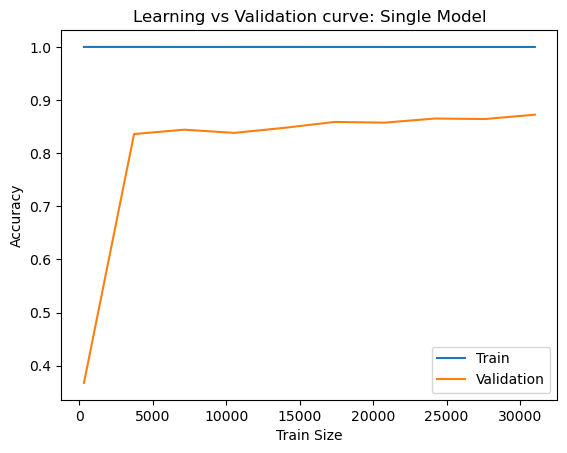

In [6]:
# Training and validation learning curves for a single model
train_sizes, train_scores, val_scores = learning_curve(tree, X_tr, y_tr, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 10))

train_mean = np.mean(train_scores, axis = 1)
validation_mean = np.mean(val_scores, axis=1)

print(train_sizes)
print(train_mean)
print(validation_mean)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, validation_mean, label="Validation")
plt.title("Learning vs Validation curve: Single Model")
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
# Train an ensemble of decision tree classifiers using Adaboost

base_classifier = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=20)

# Train the AdaBoost classifier on the training data
adaboost_classifier.fit(X_tr, y_tr)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

training_accuracy = adaboost_classifier.score(X_tr, y_tr)
print("Training accuracy:", training_accuracy)

testing_accuracy = adaboost_classifier.score(X_test, y_test)
print("Testing accuracy:", testing_accuracy)

Accuracy: 0.8067972543110664
Training accuracy: 0.9999354963555441
Testing accuracy: 0.8067972543110664


[  310  3720  7131 10542 13952 17363 20774 24184 27595 31006]
[1.         1.         0.99995326 0.99996838 0.99997611 0.9999616
 0.99995186 0.99993108 0.9999396  0.99994625]
[0.16773098 0.84295513 0.83674128 0.84211658 0.84699736 0.85684491
 0.86069363 0.86611194 0.87307833 0.87019717]


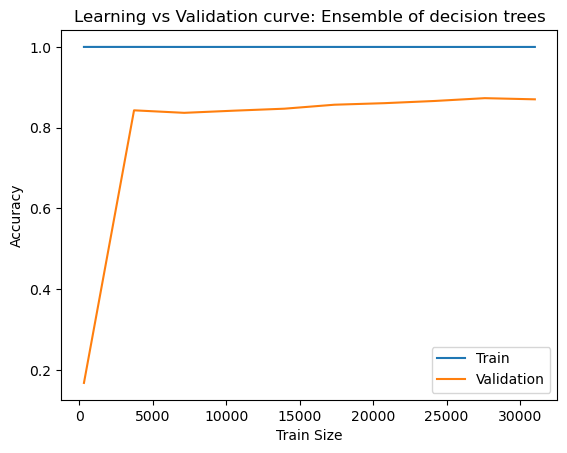

In [8]:
# Training and validation learning curves for the ensemble of decision trees

train_sizes, train_scores, val_scores = learning_curve(adaboost_classifier, X_tr, y_tr, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 10))

train_mean = np.mean(train_scores, axis = 1)
validation_mean = np.mean(val_scores, axis=1)

print(train_sizes)
print(train_mean)
print(validation_mean)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, validation_mean, label="Validation")
plt.title("Learning vs Validation curve: Ensemble of decision trees")
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
# Stacking adaboost classifier with another classifier, else not necessary as only 2 marks

In [10]:
''' Show the relationship between the error rate of the ensemble,
the error rate of individual base models, and the number of base models
'''
expected_error_com = []
expected_error_av = []

# Define the range of base models (e.g., from 1 to 19)
num_base_models_range = np.arange(5,55,5)

# Train and evaluate AdaBoost with different numbers of base models
for num_models in num_base_models_range:
    sum_squared_error = 0
    sum_error = 0
    # Create AdaBoost classifier with DecisionTree base models
    ada_boost_model = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=num_models)
    
    # Train the ensemble
    ada_boost_model.fit(X_tr, y_tr)
    for classifier in adaboost_classifier.estimators_:
        y_pred = classifier.predict(X_test)

        # Calculate accuracy and error rate
        accuracy = accuracy_score(y_test, y_pred)
        error_rate = 1 - accuracy

        accuracy = accuracy_score(y_test, y_pred)
        # print(f"Accuracy: {accuracy}")
        sum_squared_error += (error_rate)**2
        sum_error += (error_rate)
    e_av = sum_squared_error/num_models
    e_com = (sum_error/num_models)**2

    # Append error rates to lists
    expected_error_av.append(e_av)
    expected_error_com.append(e_com)

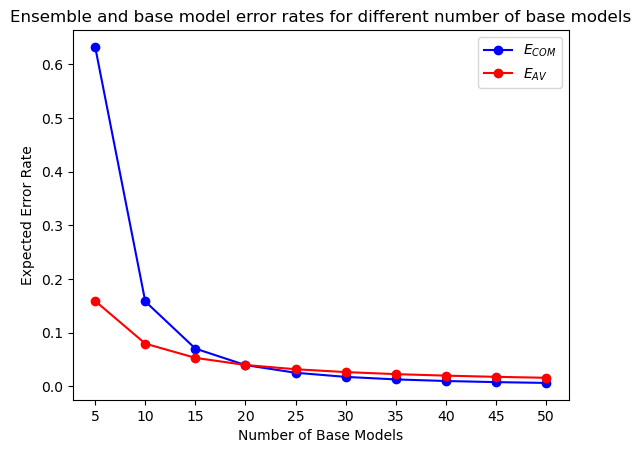

[0.6323617851849591, 0.15809044629623978, 0.07026242057610657, 0.039522611574059945, 0.02529447140739836, 0.017565605144026643, 0.012905342554795085, 0.009880652893514986, 0.007806935619567395, 0.00632361785184959]
[0.15902511129874042, 0.07951255564937021, 0.053008370432913475, 0.039756277824685105, 0.031805022259748086, 0.026504185216456738, 0.0227178730426772, 0.019878138912342552, 0.01766945681097116, 0.015902511129874043]


In [11]:
x_values = range(len(num_base_models_range))
plt.plot(x_values, expected_error_com, marker="o", c="blue", label="$E_{COM}$")
plt.plot(x_values, expected_error_av, marker="o", c="red", label="$E_{AV}$")

plt.xticks(x_values, num_base_models_range)

plt.title("Ensemble and base model error rates for different number of base models")
plt.xlabel("Number of Base Models")
plt.ylabel("Expected Error Rate")
plt.legend(loc="best")
plt.show()
print(expected_error_com)
print(expected_error_av)

## DecisionTreeClassifier() Hyperparameter Tuning

In [12]:
# Hyperparameters to tune:
'''
DecisionTreeClassifier:
    max_depth: yes
        - Increasing this value can lead to a more complex model,
        but it also increases the risk of overfitting.
    min_samples_split: yes
        - The minimum number of samples required to split an internal node.
        Increasing this value can prevent the tree from splitting too early, avoiding overfitting.
        - If it's a float, then min_samples_split is a fraction
        and ceil(min_samples_split * n_samples) are the minimum
        number of samples for each split.
    min_samples_leaf: yes
        - Similar to hyperparameter above, helps control overfitting
        - If it's a float, then min_samples_leaf is a fraction and ceil
        (min_samples_leaf * n_samples) are the minimum number of samples for each node.
    max_features: yes
        - The number of features to consider when looking for the best split.
        This parameter can be crucial for controlling the tree's complexity.
'''

"\nDecisionTreeClassifier:\n    max_depth: yes\n        - Increasing this value can lead to a more complex model,\n        but it also increases the risk of overfitting.\n    min_samples_split: yes\n        - The minimum number of samples required to split an internal node.\n        Increasing this value can prevent the tree from splitting too early, avoiding overfitting.\n        - If it's a float, then min_samples_split is a fraction\n        and ceil(min_samples_split * n_samples) are the minimum\n        number of samples for each split.\n    min_samples_leaf: yes\n        - Similar to hyperparameter above, helps control overfitting\n        - If it's a float, then min_samples_leaf is a fraction and ceil\n        (min_samples_leaf * n_samples) are the minimum number of samples for each node.\n    max_features: yes\n        - The number of features to consider when looking for the best split.\n        This parameter can be crucial for controlling the tree's complexity.\n"

In [13]:
# max_depth:

# define the parameter grid for max_depth
param_grid = {'max_depth': np.arange(1, 26, 2)}

# Create an DecisionTreeClassifier classifier
tree =  DecisionTreeClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
max_depths = param_grid['max_depth']

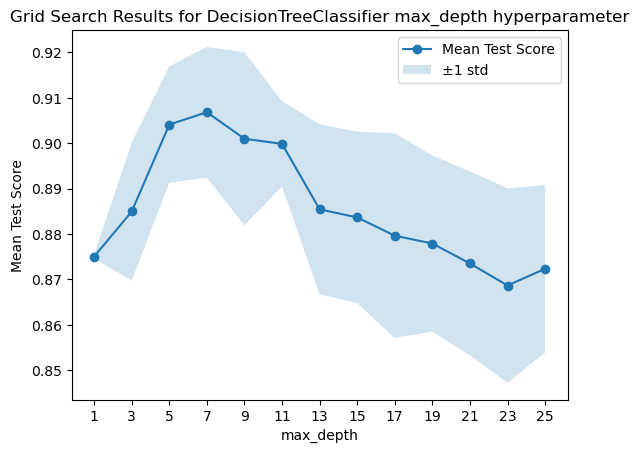

In [14]:
# Plot the results

x_values = range(len(max_depths))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, max_depths)
plt.title("Grid Search Results for DecisionTreeClassifier max_depth hyperparameter")
plt.xlabel("max_depth")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [15]:
# min_samples_split:

# define the parameter grid for min_samples_split
param_grid = {'min_samples_split': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]}

# Create an DecisionTreeClassifier classifier
tree =  DecisionTreeClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
min_samples_split = param_grid['min_samples_split']

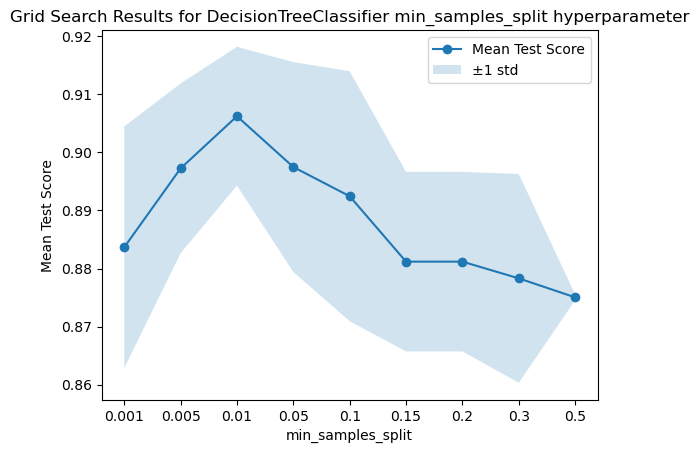

In [16]:
# Plot the results

x_values = range(len(min_samples_split))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, min_samples_split)
plt.title("Grid Search Results for DecisionTreeClassifier min_samples_split hyperparameter")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [17]:
# min_samples_leaf:

# define the parameter grid for min_samples_split
param_grid = {'min_samples_leaf': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]}

# Create an DecisionTreeClassifier classifier
tree =  DecisionTreeClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
min_samples_leaf = param_grid['min_samples_leaf']

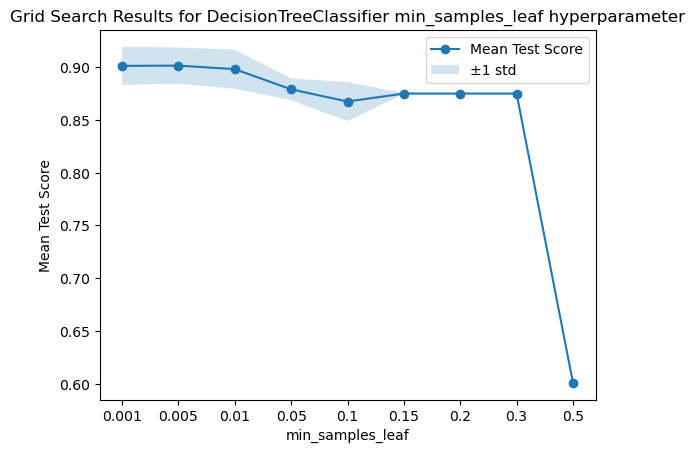

In [18]:
# Plot the results

x_values = range(len(min_samples_leaf))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, min_samples_split)
plt.title("Grid Search Results for DecisionTreeClassifier min_samples_leaf hyperparameter")
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [19]:
# max_features:

# define the parameter grid for min_samples_split
param_grid = {'max_features': ["auto", "sqrt", "log2"]}

# Create an DecisionTreeClassifier classifier
tree =  DecisionTreeClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
max_features = param_grid['max_features']


C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


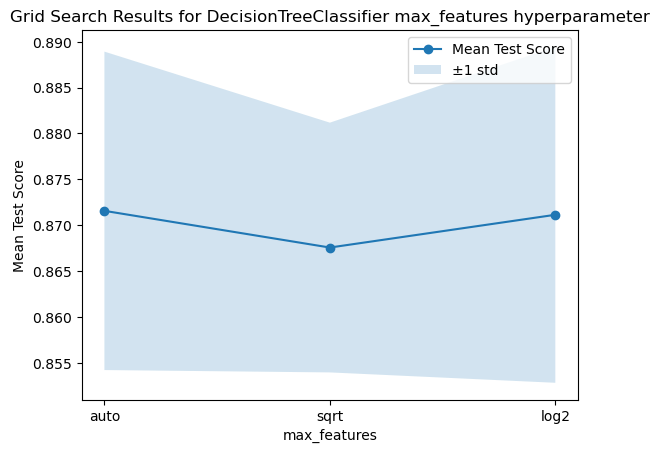

In [20]:
# Plot the results

x_values = range(len(max_features))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, max_features)
plt.title("Grid Search Results for DecisionTreeClassifier max_features hyperparameter")
plt.xlabel("max_features")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [21]:
# Best combination of hyperparameters
param_grid = {'max_depth': np.arange(1, 26, 2),
              'min_samples_split': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5],
              'min_samples_leaf': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
             }

# Create an DecisionTreeClassifier classifier
tree =  DecisionTreeClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Print the best hyperparameters
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Best Hyperparameters: {'max_depth': 13, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01}
Test Accuracy with Best Hyperparameters: 0.8299012221664155


## DecisionTreeClassifier() Hyperparameter Tuning

In [22]:
'''
AdaBoostClassifier:
    n_estimators:
        - The number of base estimators (decision trees) in the ensemble.
    learning_rate:
        - Shrinks the contribution of each base estimator.
        Lower values often lead to better generalization.
        - Weight applied to each classifier at each boosting iteration.
        A higher learning rate increases the contribution of each classifier.

'''

'\nAdaBoostClassifier:\n    n_estimators:\n        - The number of base estimators (decision trees) in the ensemble.\n    learning_rate:\n        - Shrinks the contribution of each base estimator.\n        Lower values often lead to better generalization.\n        - Weight applied to each classifier at each boosting iteration.\n        A higher learning rate increases the contribution of each classifier.\n\n'

In [23]:
# Checking the best hyperparameters
print(best_hyperparameters)
best_max_depth = best_hyperparameters["max_depth"]
best_min_samples_leaf = best_hyperparameters["min_samples_leaf"]
best_min_samples_split = best_hyperparameters["min_samples_split"]

# print(best_max_depth)
# print(best_min_samples_leaf)
# print(best_min_samples_split)

{'max_depth': 13, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01}


In [24]:
# n_estimators:

# define the parameter grid for n_estimators
param_grid = {'n_estimators': np.arange(5, 101, 5)}

# Create a DecisionTreeClassifier classifier with previously calculated optimium hyperparameters
base_classifier = DecisionTreeClassifier(max_depth=best_max_depth,
                                         min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split=best_min_samples_split)

# Train an ensemble of decision tree classifiers using Adaboost
adaboost_classifier = AdaBoostClassifier(base_classifier)

# Perform GridSearchCV
grid_search = GridSearchCV(adaboost_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
n_estimators = param_grid['n_estimators']


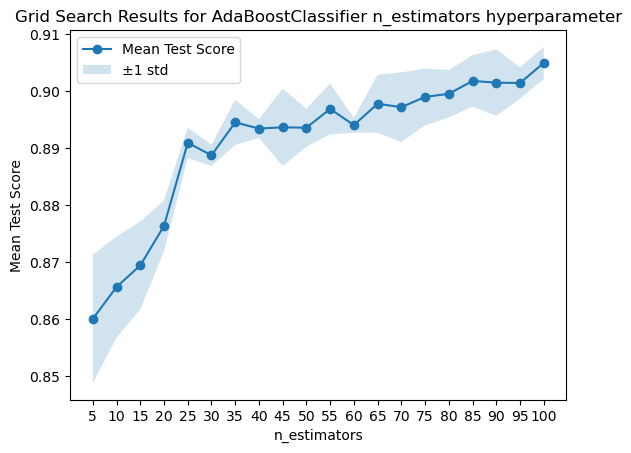

In [25]:
# Plot the results

x_values = range(len(n_estimators))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, n_estimators)
plt.title("Grid Search Results for AdaBoostClassifier n_estimators hyperparameter")
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [31]:
# learning_rate:

# define the parameter grid for learning_rate
param_grid = {'learning_rate': np.arange(2, 21, 2)/2}

# Create a DecisionTreeClassifier classifier with previously calculated optimium hyperparameters
base_classifier = DecisionTreeClassifier(max_depth=best_max_depth,
                                         min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split=best_min_samples_split)

# Train an ensemble of decision tree classifiers using Adaboost
adaboost_classifier = AdaBoostClassifier(base_classifier)

# Perform GridSearchCV
grid_search = GridSearchCV(adaboost_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
learning_rate = param_grid['learning_rate']


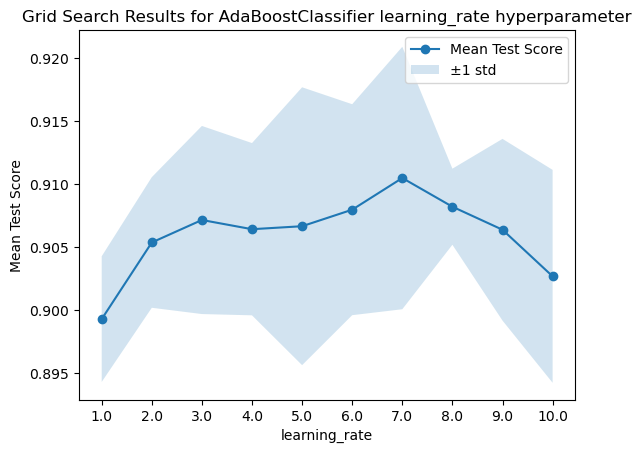

In [32]:
# Plot the results

x_values = range(len(learning_rate))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, learning_rate)
plt.title("Grid Search Results for AdaBoostClassifier learning_rate hyperparameter")
plt.xlabel("learning_rate")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()